 ### Canonical Correlation Analysis

 Goal: compare the neural representations between V1 and V2

 Let $X$ and $Y$ be an $(n \times p)$ matrix where $n$ is the number of stimuli and $p$ is the number of neurons.

 We first split the spiking data of each region into two for a comparison between intra-region and inter-region CCA. Hence, we have 3 different CCA models to fit.

 | $X$ | $Y$ |
 |------|------|
 | V1-1 | V1-2 |
 | V1-1 | V2-1 |
 | V2-1 | V2-2 |

 Then, for each group, we split the spiking data by stimulus into train and test sets.

In [1]:
%cd ..
%config InlineBackend.figure_format='retina'

import altair as alt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.subspace_comm import CCARepeatedStim
from src.gabor_analysis.gabor_fit import GaborFit
from src.spikeloader import SpikeLoader

alt.data_transformers.disable_max_rows()
# alt.renderers.enable("mimetype")
sns.set()

/Users/chaichontat/Documents/GitHub/janelia2020


In [2]:
def gen_chart(data: pd.DataFrame) -> alt.Chart:
    return (
        alt.Chart(data[data.split == 'test'])
        .mark_line(opacity=0.5)
        .encode(
            x=alt.X("dimension:Q"),  # , scale=alt.Scale(domain=xlim)),
            y=alt.Y("coef:Q"),  # , scale=alt.Scale(domain=ylim)),
            color="n:N",
            column=alt.Column("regions:N"),
        )
    ).properties(width=200, height=300)


cr = CCARepeatedStim(
    SpikeLoader.from_hdf5("data/processed.hdf5"), GaborFit.from_hdf5("data/gabor.hdf5")
)
n_train = [500, 1000, 2000, 5000, 10000]

/Users/chaichontat/Documents/GitHub/janelia2020/scripts/subspace_comm.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sampled["group"] = 0
/Users/chaichontat/miniconda3/envs/janelia2020/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/chaichontat/Documents/GitHub/janelia2020/scripts/subspace_comm.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

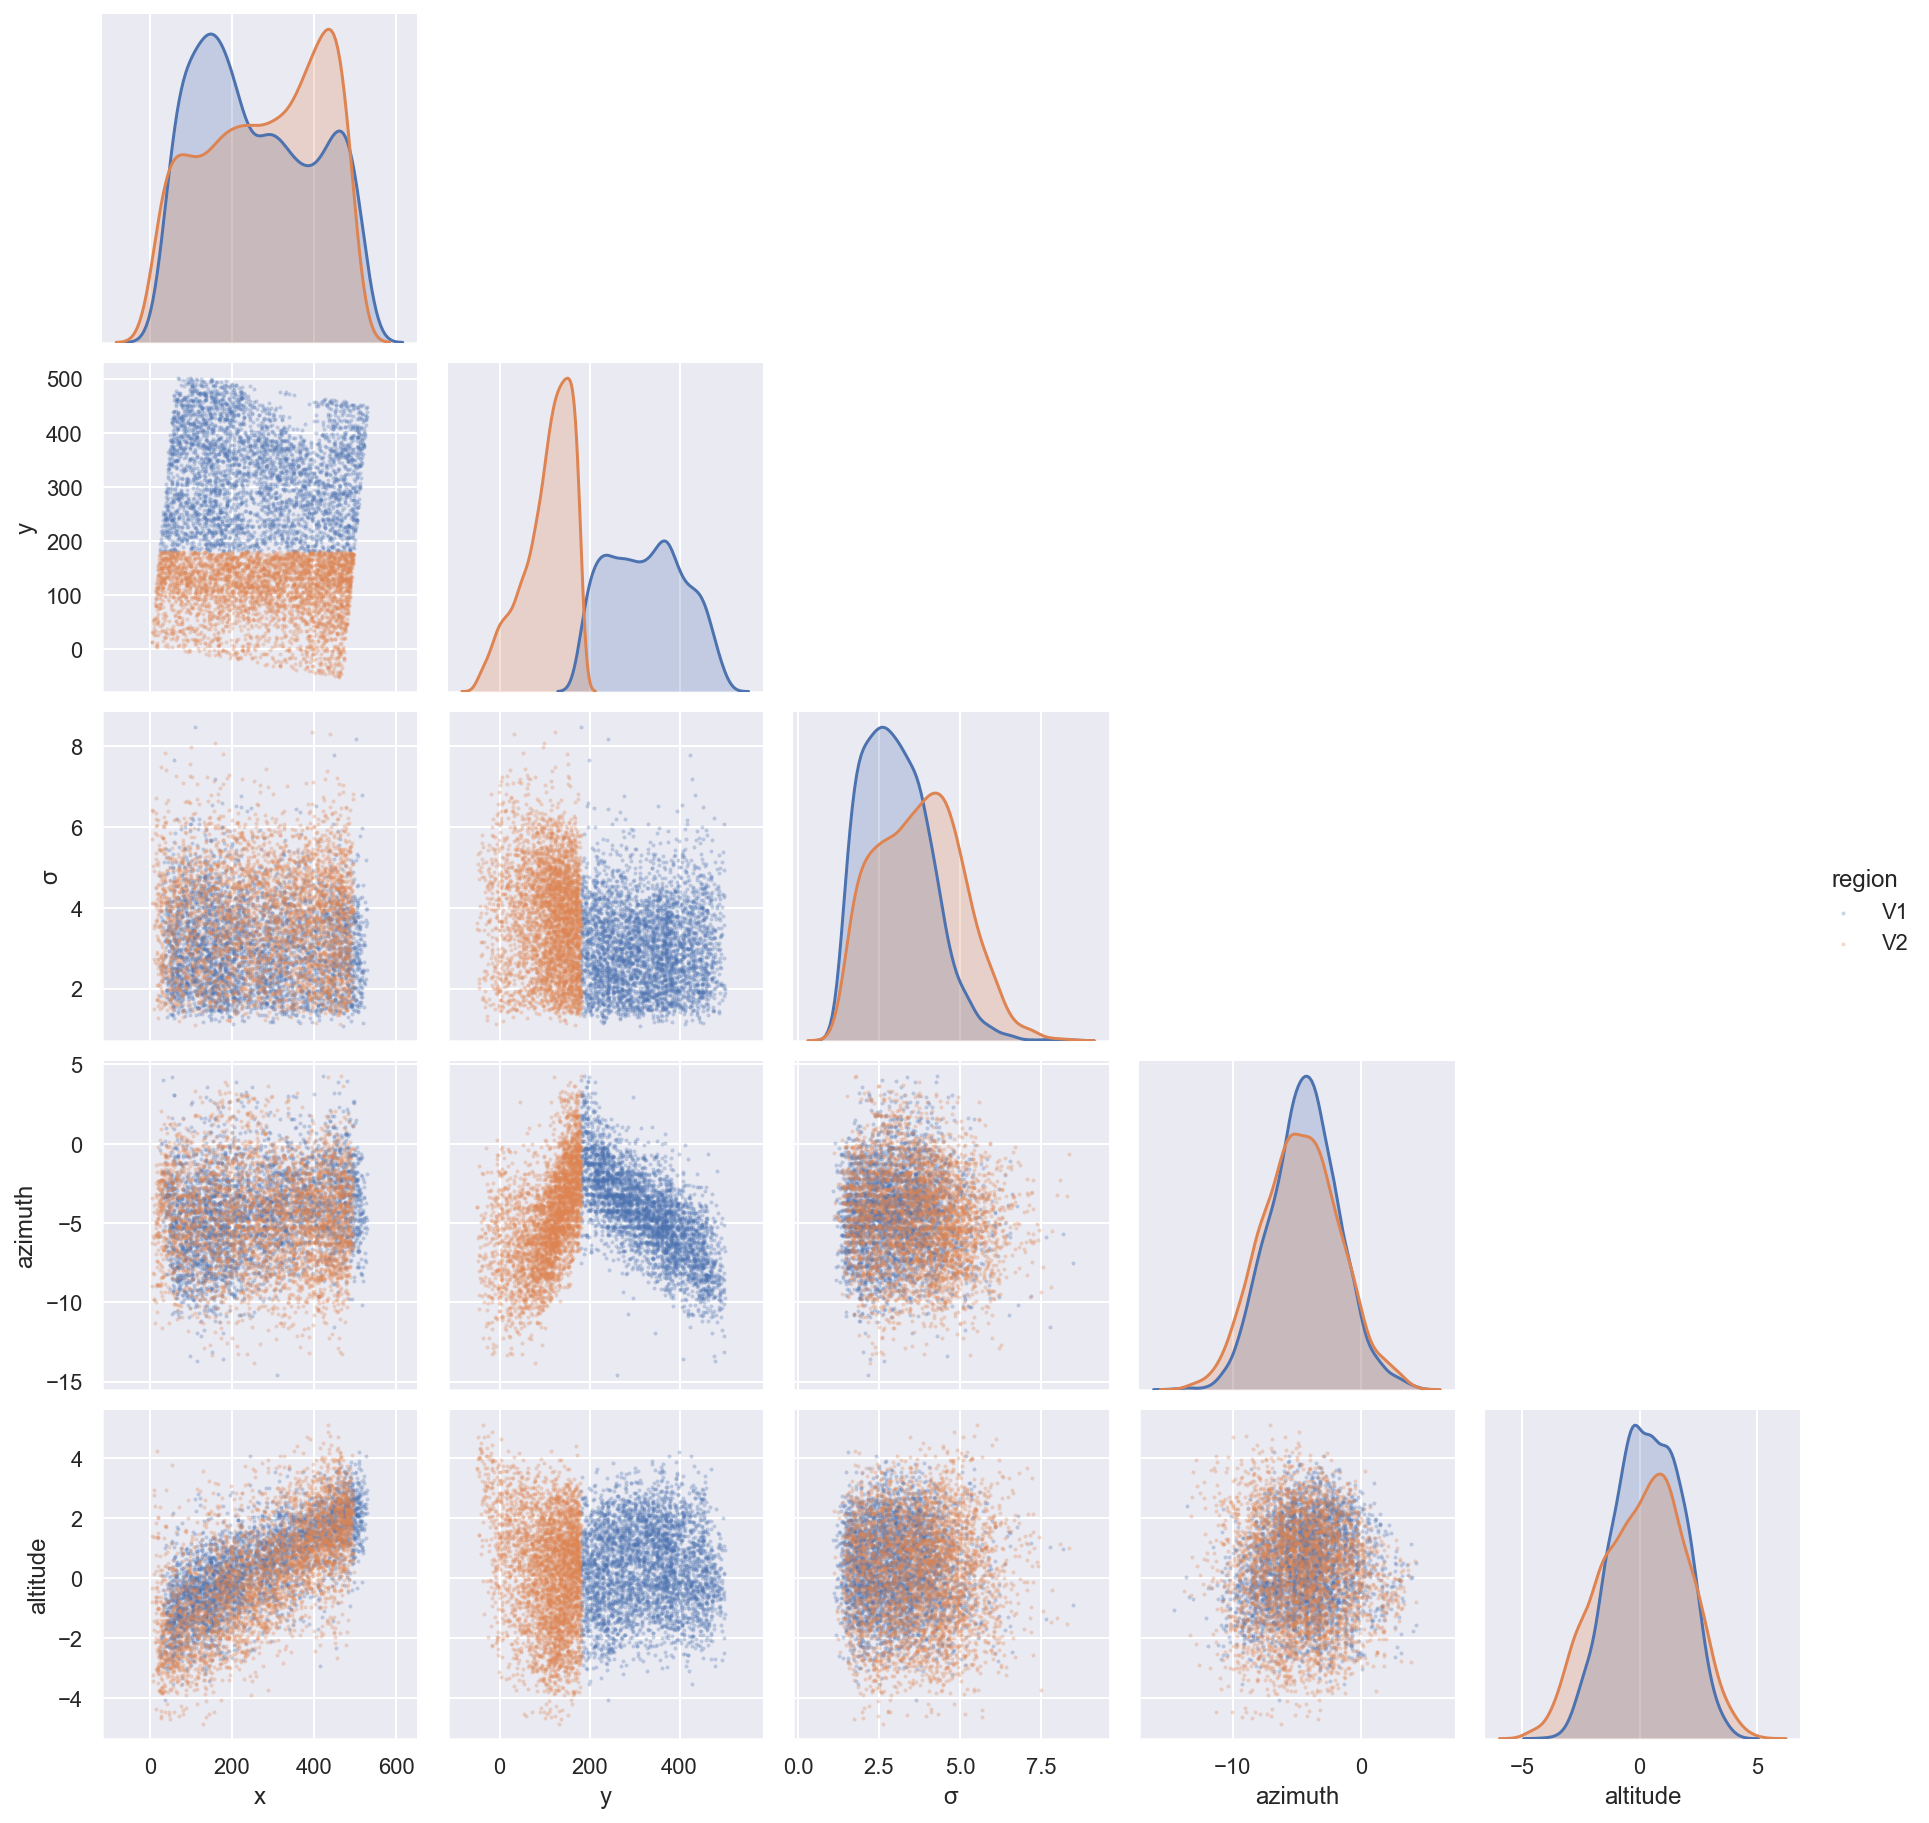

In [3]:
sns.pairplot(
    cr.df,
    hue="region",
    vars=["x", "y", "σ", "azimuth", "altitude"],
    corner=True,
    plot_kws=dict(s=4, linewidth=0, alpha=0.3),
)

There is a sharp increase in sampled neuron at the V1-V2 boundary. This is due to the fact that V1 neurons outnumber V2 neurons by 60%. Furthermore, the azimuthal preferences of V2 neurons extend include more of the lateral visual field, reducing the number of potential matches with V1.

We perform CCA with an 80:20 train:test stimuli split with various numbers of training stimuli.

In [4]:
df_rand = cr.run_random_splits(n_train=n_train)
gen_chart(df_rand)

/Users/chaichontat/miniconda3/envs/janelia2020/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


alt.Chart(...)

The test set now contains responses from the second repeat of the repeated stimuli. Here, we test whether the presence of the responses to an identical set of stimuli in the training set would affect the results.

In [5]:
df_repeated = cr.run_repeated_splits(n_train=n_train)
gen_chart(df_repeated[df_repeated.split == 'test']).encode(alt.Row("test_stim_in_train")).properties(
    title=("Canonical Coefficients: Repeated Stimuli"), height=200
)

alt.Chart(...)

### Verify Train/Test Split
First, we check if the indices are correct.

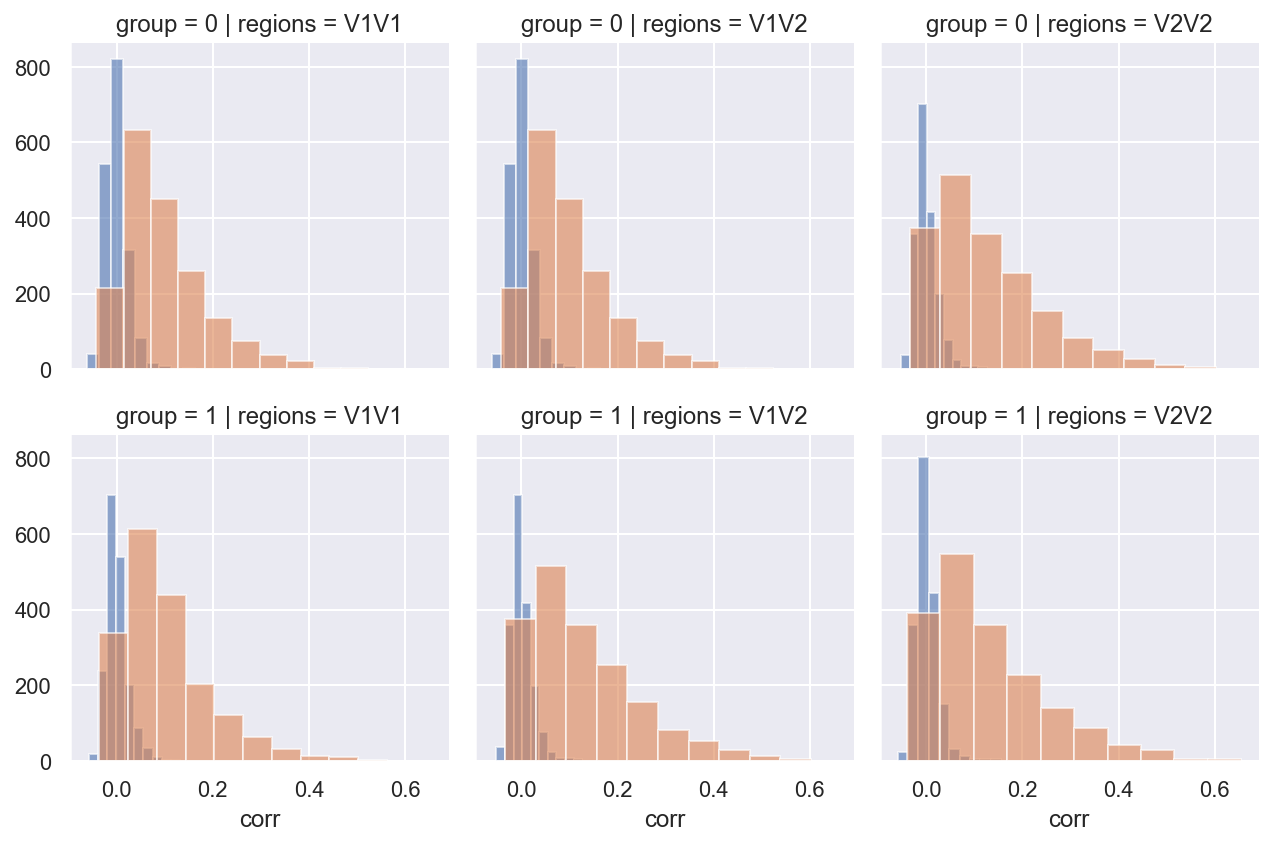

In [6]:
df_corr = cr.calc_repeated_corr(n=2000)
sns.FacetGrid(df_corr, col="regions", row="group", hue="test_stim_in_train").map(
    plt.hist, "corr", alpha=0.6
)

How does training on an unreleated stimuli affect things?

In [7]:
df_un = cr.run_unrepeated(n_train=n_train)
corr_between_tests = cr.corr_between_test(df_un)

Here, we generate canonical vectors from all unrepeated stimuli. These are then used to separately generate canonical variates for the repeated stimuli. We then calculate the correlation (canonical coefficient) within and between repeats.

In [9]:
alt.Chart(corr_between_tests).mark_line(opacity=0.5).encode(
    x='dimension',
    y='corr',
    column='regions',
    row='n:N',
    color='match'
).properties(width=150, height=150)

alt.Chart(...)